In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
# import plots
import seaborn as sns

In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files'

country = 'Mexico'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
    buffer = 8000
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
    buffer = 8000
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
    buffer = 2000
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'
    buffer = 8000
    

## Test grid works

In [3]:
directory = '/Volumes/RECAST/data/movements/' + country
files = sorted(os.listdir(directory))
files = [file for file in files if '_0800.csv' in file]

# grid_mov = gpd.read_file('/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files/data/inputs/grids/Grid_' + country + '/Grid_' + country + '.shp').to_crs('EPSG:4326')
grid_mov = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_mov/Grid_' + country + '.shp').to_crs('EPSG:4326')



In [4]:
df_movs = pd.read_csv(directory + '/' + files[100])
df_movs = df_movs[df_movs['country']==country_code].reset_index(drop=True)

In [5]:
start_lstr_lons = []
start_lstr_lats = []
end_lstr_lons = []
end_lstr_lats = []

for j in range(len(df_movs)):
    try:
        start_lstr_lons.append(float(df_movs.loc[j, 'geometry'].split("(")[1].split(",")[0].split(" ")[0]))
        start_lstr_lats.append(float(df_movs.loc[j, 'geometry'].split("(")[1].split(",")[0].split(" ")[1]))
        end_lstr_lons.append(float(df_movs.loc[j, 'geometry'].split(", ")[1].split(")")[0].split(" ")[0]))
        end_lstr_lats.append(float(df_movs.loc[j, 'geometry'].split(", ")[1].split(")")[0].split(" ")[1]))
    except:
        start_lstr_lons.append(float(df_movs.loc[j, 'GEOMETRY'].split("(")[1].split(",")[0].split(" ")[0]))
        start_lstr_lats.append(float(df_movs.loc[j, 'GEOMETRY'].split("(")[1].split(",")[0].split(" ")[1]))
        end_lstr_lons.append(float(df_movs.loc[j, 'GEOMETRY'].split(", ")[1].split(")")[0].split(" ")[0]))
        end_lstr_lats.append(float(df_movs.loc[j, 'GEOMETRY'].split(", ")[1].split(")")[0].split(" ")[1]))
df_movs['start_lstr_lat'] = start_lstr_lats
df_movs['start_lstr_lon'] = start_lstr_lons
df_movs['end_lstr_lat'] = end_lstr_lats
df_movs['end_lstr_lon'] = end_lstr_lons

gdf_movs = gpd.GeoDataFrame(df_movs, geometry=gpd.points_from_xy(df_movs.start_lstr_lon, df_movs.start_lstr_lat), crs="EPSG:4326")
                            

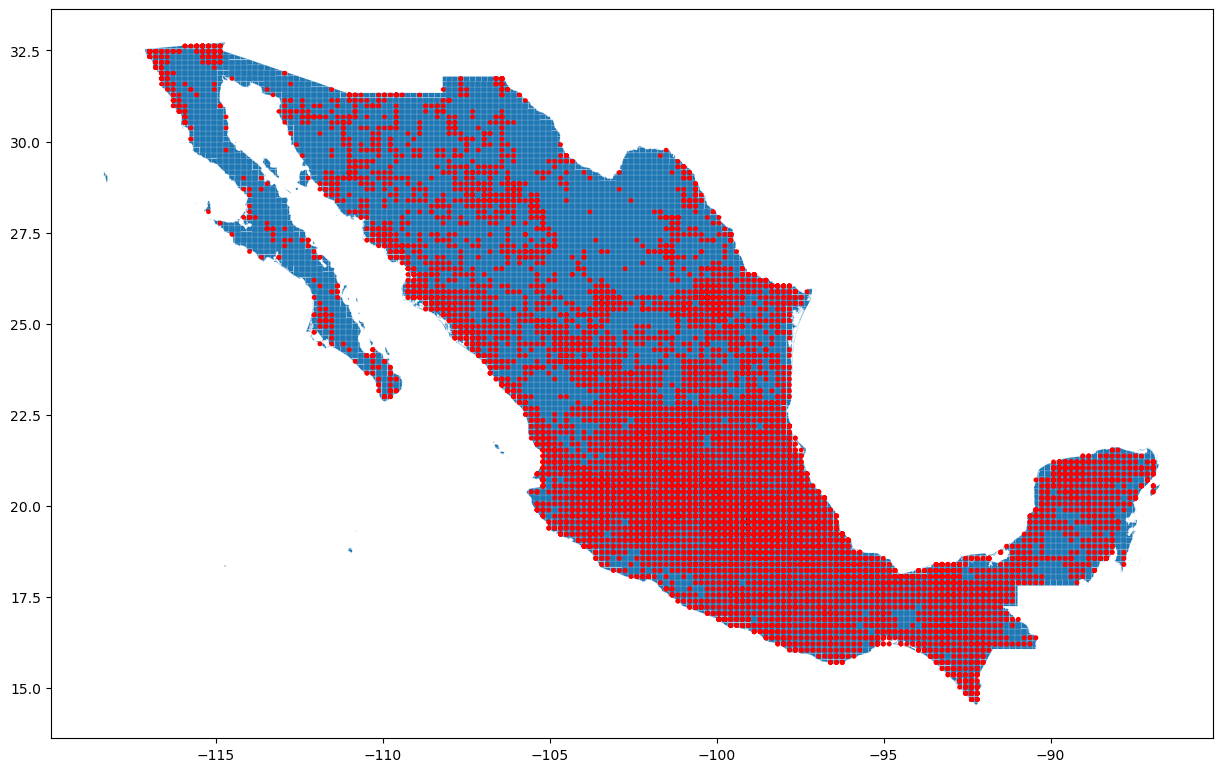

In [6]:
fig,ax = plt.subplots(figsize=(15,15))
    
grid_mov.plot(ax=ax, lw=0.1, ec='w', zorder=1)

gdf_buff = gdf_movs.to_crs('EPSG:3857').buffer(buffer).to_crs('EPSG:4326')
gdf_buff.plot(ax=ax, zorder=2, color='red')

# ax.set_xlim(-75, -74)
# ax.set_ylim(4, 5)

plt.show()

## Add IDs to movement data

In [7]:
directory = '/Volumes/RECAST/data/movements/' + country
files = sorted(os.listdir(directory))
files = [file for file in files if '_0800.csv' in file]

In [8]:
for i in range(len(files)):

    if i%20 == 0:
        print('progress ', i/len(files)*100, '%')

    try:

        file = files[i]

        df_movs = pd.read_csv(directory + '/' + file)
        df_movs = df_movs[df_movs['country']==country_code].reset_index(drop=True)
    #         df_movs = df_movs[df_movs['length_km'] < 70].reset_index(drop=True)

        start_lstr_lons = []
        start_lstr_lats = []
        end_lstr_lons = []
        end_lstr_lats = []

        for j in range(len(df_movs)):
            try:
                start_lstr_lons.append(float(df_movs.loc[j, 'geometry'].split("(")[1].split(",")[0].split(" ")[0]))
                start_lstr_lats.append(float(df_movs.loc[j, 'geometry'].split("(")[1].split(",")[0].split(" ")[1]))
                end_lstr_lons.append(float(df_movs.loc[j, 'geometry'].split(", ")[1].split(")")[0].split(" ")[0]))
                end_lstr_lats.append(float(df_movs.loc[j, 'geometry'].split(", ")[1].split(")")[0].split(" ")[1]))
            except:
                start_lstr_lons.append(float(df_movs.loc[j, 'GEOMETRY'].split("(")[1].split(",")[0].split(" ")[0]))
                start_lstr_lats.append(float(df_movs.loc[j, 'GEOMETRY'].split("(")[1].split(",")[0].split(" ")[1]))
                end_lstr_lons.append(float(df_movs.loc[j, 'GEOMETRY'].split(", ")[1].split(")")[0].split(" ")[0]))
                end_lstr_lats.append(float(df_movs.loc[j, 'GEOMETRY'].split(", ")[1].split(")")[0].split(" ")[1]))
        df_movs['start_lstr_lat'] = start_lstr_lats
        df_movs['start_lstr_lon'] = start_lstr_lons
        df_movs['end_lstr_lat'] = end_lstr_lats
        df_movs['end_lstr_lon'] = end_lstr_lons

        df_movs['start_FID'] = np.ones(len(df_movs))*(-1)
        df_movs['end_FID'] = np.ones(len(df_movs))*(-1)
        index_to_drop = []
        for j in range(len(df_movs)):
            try:
                start = gpd.GeoDataFrame({'geometry': [Point(df_movs.loc[j, 'start_lstr_lon'], df_movs.loc[j, 'start_lstr_lat'])]}).set_crs('EPSG:4326')
                start = start.to_crs('EPSG:3857').buffer(buffer).to_crs('EPSG:4326')
                overlap_start = start[0].intersects(grid_mov['geometry'])
                df_movs.loc[j, 'start_FID'] = grid_mov.loc[np.where(overlap_start == True)[0][0]]['FID']
                end = gpd.GeoDataFrame({'geometry': [Point(df_movs.loc[j, 'end_lstr_lon'], df_movs.loc[j, 'end_lstr_lat'])]}).set_crs('EPSG:4326')
                end = end.to_crs('EPSG:3857').buffer(buffer).to_crs('EPSG:4326')
                overlap_end = end[0].intersects(grid_mov['geometry'])
                df_movs.loc[j, 'end_FID'] = grid_mov.loc[np.where(overlap_end == True)[0][0]]['FID']
            except:
                print(i, j)
                index_to_drop.append(j)

        df_movs = df_movs.drop(index_to_drop).reset_index(drop=True)

        df_movs.to_csv(wd + '/data/outputs/' + country_short + '/mov/' + file)

    except:
        print('nah', i)

#         wd + '/data/outputs/' + country_short + '/mov/' + file)

progress  0.0 %
progress  2.6246719160104988 %
progress  5.2493438320209975 %
progress  7.874015748031496 %
progress  10.498687664041995 %
progress  13.123359580052494 %
progress  15.748031496062993 %
progress  18.37270341207349 %
progress  20.99737532808399 %
progress  23.62204724409449 %
progress  26.246719160104988 %
progress  28.871391076115486 %
progress  31.496062992125985 %
progress  34.120734908136484 %
progress  36.74540682414698 %
progress  39.37007874015748 %
progress  41.99475065616798 %
progress  44.61942257217848 %
progress  47.24409448818898 %
progress  49.86876640419948 %
progress  52.493438320209975 %
progress  55.118110236220474 %
progress  57.74278215223097 %
progress  60.367454068241464 %
progress  62.99212598425197 %
progress  65.61679790026247 %
progress  68.24146981627297 %
progress  70.86614173228347 %
progress  73.49081364829397 %
progress  76.11548556430446 %
progress  78.74015748031496 %
progress  81.36482939632546 %
progress  83.98950131233596 %
progress  86

In [9]:
i

761